# Importing Libraries

In [ ]:
import torchaudio
import torchaudio.transforms as T
import librosa.display
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import cmudict

# Downloading cmudict

In [ ]:
nltk.download('cmudict')
cmu_dict = cmudict.dict()

[nltk_data] Downloading package cmudict to /root/nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


# Loading Data

In [ ]:
audio_path = "/content/LJ001-0030.wav"
waveform, sample_rate = torchaudio.load(audio_path)

# Convert to Mono & Resample to 16kHz

In [ ]:
resampler = T.Resample(orig_freq=sample_rate, new_freq=16000)
waveform = resampler(waveform.mean(dim=0, keepdim=True))

# Loading Wav2Vec2 Model

In [ ]:
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-large-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-large-960h")

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-large-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Processing Audio for Word Recognition


In [ ]:
input_values = processor(waveform.squeeze().numpy(), return_tensors="pt", sampling_rate=16000).input_values
with torch.no_grad():
    logits = model(input_values).logits

# Converting logits to predicted tokens


In [ ]:
predicted_ids = torch.argmax(logits, dim=-1)
transcription = processor.batch_decode(predicted_ids)[0].upper()
print("Recognized Text:", transcription)

Recognized Text: A VERY FEW YEARS SAW THE BIRTH OF ROM AN CHARACTER NOT ONLY IN ITALY BUT IN GERMANY AND FRANCE


# Converting Words to Phonemes using CMU Dictionary


In [ ]:
words = transcription.split()
phonemes = []
for word in words:
    if word in cmu_dict:
        phonemes.extend(cmu_dict[word][0])
    else:
        phonemes.append(word)

print("Recognized Phonemes:", " ".join(phonemes))

Recognized Phonemes: A VERY FEW YEARS SAW THE BIRTH OF ROM AN CHARACTER NOT ONLY IN ITALY BUT IN GERMANY AND FRANCE


# Step 6: Estimate Phoneme Time Intervals Approximate: Divide total duration by number of phonemes


In [ ]:
total_duration = waveform.shape[1] / 16000
time_intervals = np.linspace(0, total_duration, num=len(phonemes))

# Plotting Waveform and Annotate Phonemes


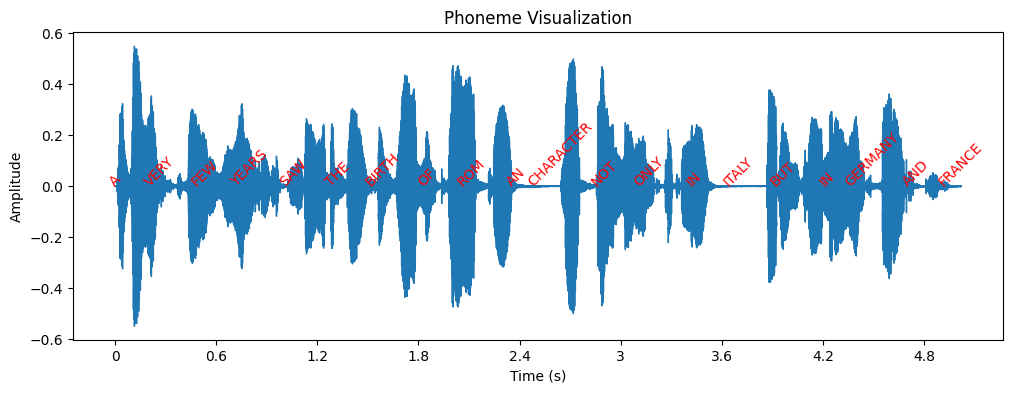

In [ ]:
plt.figure(figsize=(12, 4))
librosa.display.waveshow(waveform.squeeze().numpy(), sr=16000)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Phoneme Visualization")


for i, phoneme in enumerate(phonemes):
    if i < len(time_intervals):
        plt.text(time_intervals[i], 0, phoneme, fontsize=10, ha='center', color='red', rotation=45)

plt.show()